In [18]:
import numpy as np
import netCDF4 as nc
import pyfesom2 as pf
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import matplotlib as mpl
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import cmocean

from  scipy  import   stats

In [49]:
%%bash 
function post_echam(){
    # cdo  -select,name=var167,var169,var142,var143,var210     ${echampath}/${expid}_245???.01_echam  echam.grb
    cdo  -select,name=var167,var169     ${echampath}/${expid}_240???.01_echam  echam.grb
    cdo  -f nc -t echam6 copy  echam.grb  echam.nc
    #
    # temp2 2d climatology
    mkdir -p  output
    cdo -ymonmean -seldate,${ystart}-01-01,${yend}-12-31  -selvar,$var   echam.nc    ./output/${expid}_echam_ymonmean_${ystart}-${yend}.nc
    cdo -ymonstd  -seldate,${ystart}-01-01,${yend}-12-31  -selvar,$var   echam.nc    ./output/${expid}_echam_ymonstd_${ystart}-${yend}.nc
    rm echam.grb echam.nc 
}


expid=tran20-32k-sed10
expid=tran20-32k-sed30
ystart=2400
yend=2409
var=temp2
echampath=/home/a/a270075/ba0989/awiesm2.5/experiments-2/${expid}/outdata/echam/
post_echam 

cdo    select: Processed 17160 variables over 120 timesteps [13.94s 64MB].
cdo    copy: Processed 4423680 values from 2 variables over 120 timesteps [0.20s 30MB].
cdo(1) seldate: Process started
cdo(2) selname: Process started
cdo(2) selname: Processed 2211840 values from 2 variables over 120 timesteps.
cdo(1) seldate: Processed 2211840 values from 1 variable over 120 timesteps.
cdo    ymonmean: Processed 2211840 values from 1 variable over 120 timesteps [0.05s 39MB].
cdo(1) seldate: Process started
cdo(2) selname: Process started
cdo(2) selname: Processed 2211840 values from 2 variables over 120 timesteps.
cdo(1) seldate: Processed 2211840 values from 1 variable over 120 timesteps.
cdo    ymonstd: Processed 2211840 values from 1 variable over 120 timesteps [0.04s 41MB].


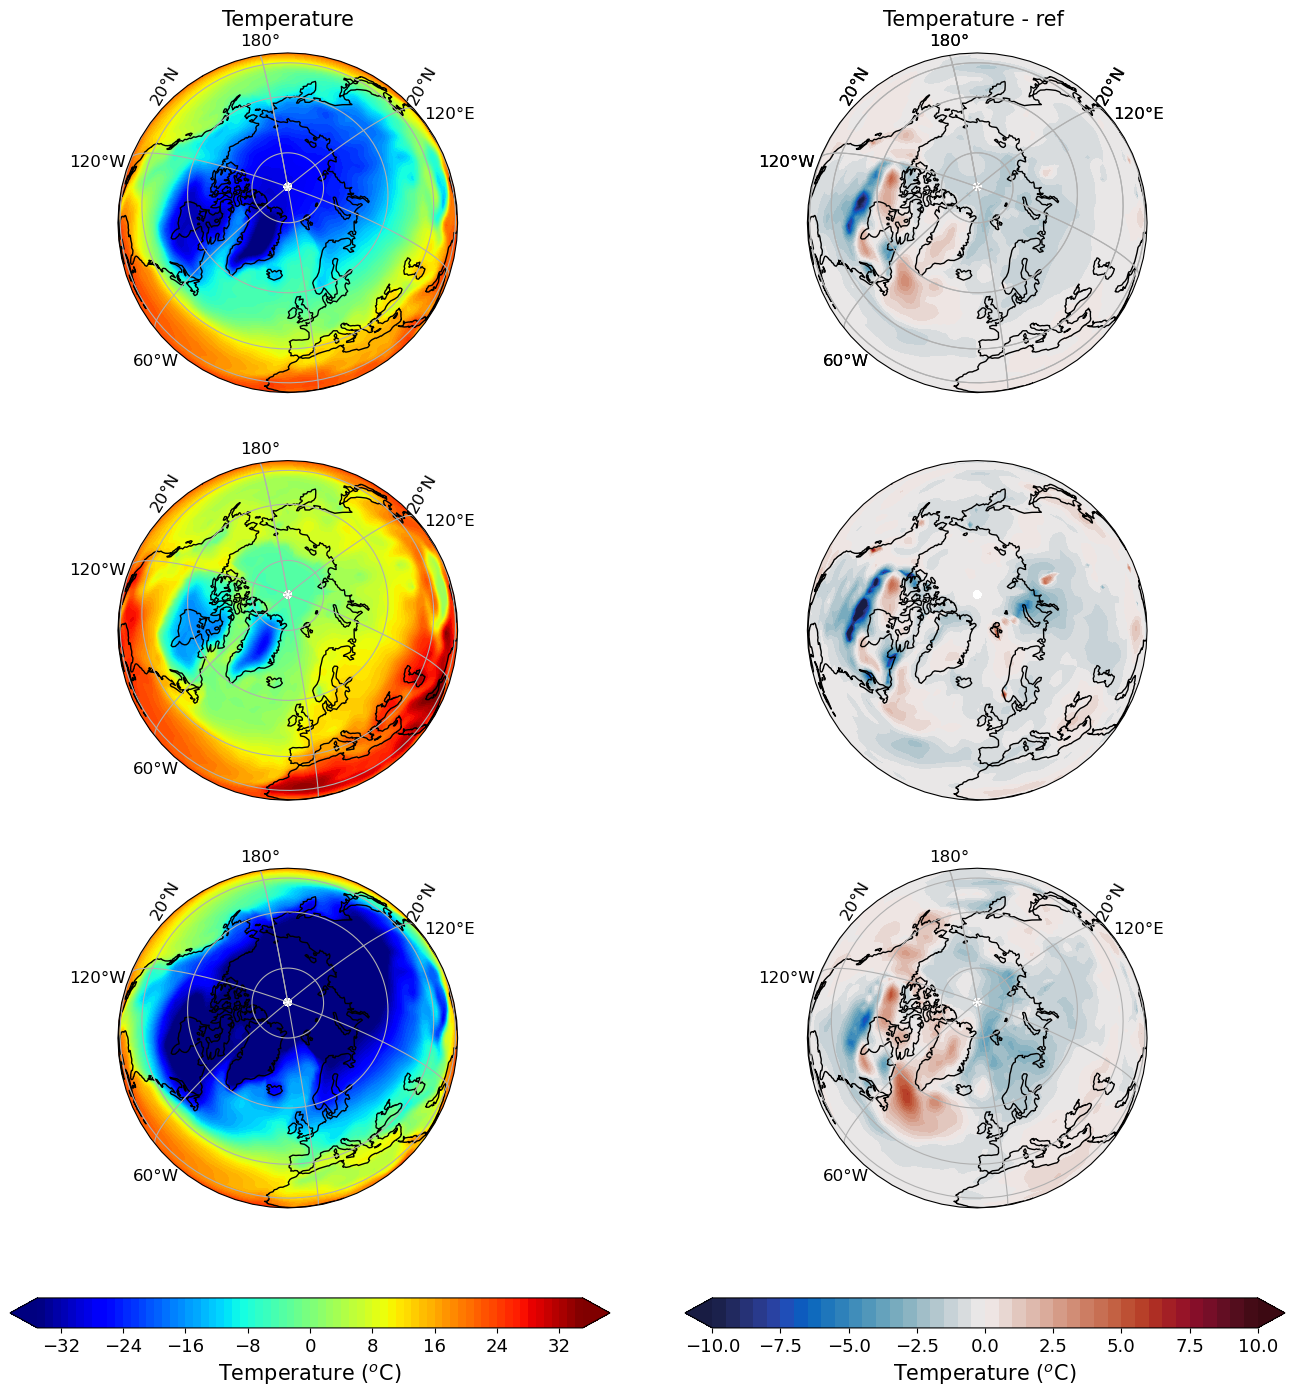

In [50]:
def JJA(data):
    data_JJA = np.mean(data[5:7,:,:],axis=0)
    return data_JJA

def DJF(data):
    data_DJF = (data[0,:,:]+data[1,:,:]+data[11,:,:])/3.
    return data_DJF

def ymean(data):
    data_out = np.mean(data[:,:,:],axis=0)
    return data_out


################################################################################


fname = './output/tran20-32k-sed10_echam_ymonmean_2400-2409.nc'
fnamestd = './output/tran20-32k-sed10_echam_ymonstd_2400-2409.nc'
nyear = 50
fnameref = './output/tran20-32k-sed30_echam_ymonmean_2400-2409.nc'
fnamerefstd = './output/tran20-32k-sed30_echam_ymonstd_2400-2409.nc'
nyearref = 50

figureout = 'plot_temp2_2d.png'



###########################################################
###########################################################
#### read data
with nc.Dataset(fname,'r') as ff:
    lon = ff.variables['lon'][:]
    lat = ff.variables['lat'][:]
    data = ff.variables['temp2'][:]-273.15

with nc.Dataset(fnamestd,'r') as ff:
    datastd = ff.variables['temp2'][:]-273.15

with nc.Dataset(fnameref,'r') as ff:
    dataref = ff.variables['temp2'][:]-273.15

with nc.Dataset(fnamerefstd,'r') as ff:
    datarefstd = ff.variables['temp2'][:]-273.15

###  calculate summer winter and annualmean, and statistcs
data_JJA = JJA(data)
data_DJF = DJF(data)
data_annualmean = ymean(data)


diff_JJA = data_JJA - JJA(dataref)
ss_JJA, pp_JJA = stats.ttest_ind_from_stats(data_JJA,JJA(datastd),nyear,JJA(dataref),JJA(datarefstd),nyearref)

diff_DJF = data_DJF - DJF(dataref)
ss_DJF, pp_DJF = stats.ttest_ind_from_stats(data_DJF,DJF(datastd),nyear,DJF(dataref),DJF(datarefstd),nyearref)

diff_annualmean = data_annualmean - ymean(dataref)
ss_annualmean, pp_annualmean = stats.ttest_ind_from_stats(data_annualmean,ymean(datastd),nyear,ymean(dataref),ymean(datarefstd),nyearref)

##########
# cyclic grids
data_JJA, lon = add_cyclic_point(data_JJA, coord=lon)
data_DJF = add_cyclic_point(data_DJF)
data_annualmean = add_cyclic_point(data_annualmean)

diff_JJA = add_cyclic_point(diff_JJA)
diff_DJF = add_cyclic_point(diff_DJF)
diff_annualmean = add_cyclic_point(diff_annualmean)
pp_JJA = add_cyclic_point(pp_JJA)
pp_DJF = add_cyclic_point(pp_DJF)
pp_annualmean = add_cyclic_point(pp_annualmean)


lons, lats = np.meshgrid(lon,lat)

cbkw = dict(orientation='horizontal', fraction=0.08,  label='SAT [$^\circ$C]')


minval=-35
maxval=35
nbreaks=71
breaks = np.linspace(minval,maxval,nbreaks)

minval2=-10
maxval2=10
nbreaks2=41
breaks2 = np.linspace(minval2,maxval2,nbreaks2)
color2 = cmocean.cm.balance
a = 0.05
hatchsty = 'xxxx'
mpl.rcParams['hatch.linewidth'] = 0.1
mpl.rcParams['hatch.color'] = 'grey'


lon_formatter = LongitudeFormatter()  #(number_format='g', degree_symbol='', dateline_direction_label=True)
lat_formatter = LatitudeFormatter()
lonticks = np.arange(-180.,180.1,60.)
latticks = np.arange(0.,90.1,30.)

proj = ccrs.PlateCarree()
# proj2 = ccrs.NorthPolarStereo(central_longitude= -45,true_scale_latitude=70.,globe=None)
proj2 = ccrs.NearsidePerspective(central_longitude=-10.0, central_latitude=80.0, satellite_height=25785831)

color = plt.cm.jet
#====================================  plot
fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(nrows=3,ncols=2,bottom=0.18,top=0.95,left=0.08,right=0.95,hspace=0.2,wspace=0.12)

#===== annual
ax1 = fig.add_subplot(gs[0,0], projection=proj2)
plt.contourf(lons,lats,data_annualmean,breaks,cmap=color,vmin=minval,vmax=maxval,extend='both',transform=proj)
ax1.coastlines()
ax1.set_global()

# grid lines
gl = ax1.gridlines(draw_labels=True) #, linewidth=2, alpha=0.4, color='k', linestyle=':')
gl.xlines = True
gl.ylines = True #False
#gl.xlocator = mticker.FixedLocator(np.arange(-180,-50, 30 ))
#gl.ylocator = mticker.FixedLocator(np.arange(20,70, 20 ))
gl.bottom_labels = False
#gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 12, 'color': 'black','rotation':0 } #'weight': 'bold'}
gl.ylabel_style = {'size': 12, 'color': 'black', 'rotation':60 } #'weight': 'bold'}

plt.ylabel('Annual', fontsize=15)
plt.title('Temperature', fontsize=15)
#===== summer
ax2 = fig.add_subplot(gs[1,0],projection=proj2)
plt.contourf(lons,lats,data_JJA,breaks,cmap=color,vmin=minval,vmax=maxval,extend='both',transform=proj)
ax2.coastlines()
ax2.set_global()

# grid lines
gl = ax2.gridlines(draw_labels=True) #, linewidth=2, alpha=0.4, color='k', linestyle=':')
gl.xlines = True
gl.ylines = True #False
#gl.xlocator = mticker.FixedLocator(np.arange(-180,-50, 30 ))
#gl.ylocator = mticker.FixedLocator(np.arange(20,70, 20 ))
gl.bottom_labels = False
#gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 12, 'color': 'black','rotation':0 } #'weight': 'bold'}
gl.ylabel_style = {'size': 12, 'color': 'black', 'rotation':60 } #'weight': 'bold'}

plt.ylabel('JJA', fontsize=15)
#===== winter
ax3 = fig.add_subplot(gs[2,0], projection=proj2)
plt.contourf(lons,lats,data_DJF,breaks,cmap=color,vmin=minval,vmax=maxval,extend='both',transform=proj)
ax3.coastlines()
ax3.set_global()

# grid lines
gl = ax3.gridlines(draw_labels=True) #, linewidth=2, alpha=0.4, color='k', linestyle=':')
gl.xlines = True
gl.ylines = True #False
#gl.xlocator = mticker.FixedLocator(np.arange(-180,-50, 30 ))
#gl.ylocator = mticker.FixedLocator(np.arange(20,70, 20 ))
gl.bottom_labels = False
#gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 12, 'color': 'black','rotation':0 } #'weight': 'bold'}
gl.ylabel_style = {'size': 12, 'color': 'black', 'rotation':60 } #'weight': 'bold'}

plt.ylabel('DJF', fontsize=15)


cax = plt.axes([0.1,0.1,0.4,0.02])
# plt.colorbar(ax=[ax1,ax2,ax3], cax=cax,  **cbkw)
cbar = plt.colorbar(ax=[ax1,ax2,ax3],cax=cax, orientation='horizontal', fraction=0.05,  )
cbar.set_label(label='Temperature ($^o$C)', size=15)
cbar.ax.tick_params(labelsize=13)
# cbar.set_ticks(np.arange(minval,maxval+0.01,10))



ax4 = fig.add_subplot(gs[0,1], projection=proj2)
ax4.contourf(lons,lats,diff_annualmean,breaks2,cmap=color2,vmin=minval2,vmax=maxval2,extend='both', transform=proj)
ax4.contourf(lons,lats,pp_annualmean,levels=[0.,0.05,1.],colors='none',hatches=[hatchsty,''], transform=proj)
ax4.coastlines()
ax4.set_global()

# grid lines
gl = ax4.gridlines(draw_labels=True) #, linewidth=2, alpha=0.4, color='k', linestyle=':')
gl.xlines = True
gl.ylines = True #False
#gl.xlocator = mticker.FixedLocator(np.arange(-180,-50, 30 ))
#gl.ylocator = mticker.FixedLocator(np.arange(20,70, 20 ))
gl.bottom_labels = False
#gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 12, 'color': 'black','rotation':0 } #'weight': 'bold'}
gl.ylabel_style = {'size': 12, 'color': 'black', 'rotation':60 } #'weight': 'bold'}

plt.title('Temperature - ref ', fontsize=15)
# #-------------
ax5 = fig.add_subplot(gs[1,1],projection=proj2)
ax5.contourf(lons,lats,diff_JJA,breaks2,cmap=color2,vmin=minval2,vmax=maxval2,extend='both', transform=proj)
ax5.contourf(lons,lats,pp_JJA,levels=[0.,0.05,1.],colors='none', hatches=[hatchsty,''], transform=proj)
ax5.coastlines()
ax4.set_global()

# grid lines
gl = ax4.gridlines(draw_labels=True) #, linewidth=2, alpha=0.4, color='k', linestyle=':')
gl.xlines = True
gl.ylines = True #False
#gl.xlocator = mticker.FixedLocator(np.arange(-180,-50, 30 ))
#gl.ylocator = mticker.FixedLocator(np.arange(20,70, 20 ))
gl.bottom_labels = False
#gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 12, 'color': 'black','rotation':0 } #'weight': 'bold'}
gl.ylabel_style = {'size': 12, 'color': 'black', 'rotation':60 } #'weight': 'bold'}



#----------
ax6 = fig.add_subplot(gs[2,1], projection=proj2)
cs = ax6.contourf(lons,lats,diff_DJF,breaks2,cmap=color2,vmin=minval2,vmax=maxval2,extend='both', transform=proj)
ax6.contourf(lons,lats,pp_DJF,levels=[0.,0.05,1.],colors='none', hatches=[hatchsty,''], transform=proj)
ax6.coastlines()
ax6.set_global()

# grid lines
gl = ax6.gridlines(draw_labels=True) #, linewidth=2, alpha=0.4, color='k', linestyle=':')
gl.xlines = True
gl.ylines = True #False
#gl.xlocator = mticker.FixedLocator(np.arange(-180,-50, 30 ))
#gl.ylocator = mticker.FixedLocator(np.arange(20,70, 20 ))
gl.bottom_labels = False
#gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 12, 'color': 'black','rotation':0 } #'weight': 'bold'}
gl.ylabel_style = {'size': 12, 'color': 'black', 'rotation':60 } #'weight': 'bold'}



cax = plt.axes([0.55,0.1,0.4,0.02])
# plt.colorbar(cs, ax=[ax4,ax5,ax6],cax=cax, **cbkw)
cbar = plt.colorbar(cs, ax=[ax4,ax5,ax6],cax=cax, orientation='horizontal', fraction=0.05,  )
cbar.set_label(label='Temperature ($^o$C)', size=15)
cbar.ax.tick_params(labelsize=13)
# cbar.set_ticks(np.arange(minval,maxval+0.01,10))
#



# plt.tight_layout()
# plt.savefig(figureout)
# plt.show(block=False)
# plt.pause(3)
# plt.close()